<a href="https://colab.research.google.com/github/ttogle918/Competition/blob/main/%ED%8C%94%EB%8B%B9%EB%8C%90%20%ED%99%8D%EC%88%98%20%EC%95%88%EC%A0%84%EC%9A%B4%EC%98%81%EC%97%90%20%EB%94%B0%EB%A5%B8%20%ED%95%9C%EA%B0%95%20%EC%88%98%EC%9C%84%EC%98%88%EC%B8%A1%20AI%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/03_poly_lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

선 본 대회의 의도는 추론하고자 하는 기간의 10분 전에, 한강의 주요 지점(다리)에 대한 수위를 예측

[팔당댐 홍수 안전운영에 따른 한강 수위예측 AI 경진대회, DACON](https://dacon.io/competitions/official/235949/data)

In [1]:
import pandas as pd
import numpy as np

from glob import glob
from tqdm import tqdm
from scipy import interpolate

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D

'''#GPU 자원이 부족한 경우 아래 코드를 이용하세요
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)'''

'#GPU 자원이 부족한 경우 아래 코드를 이용하세요\nfrom tensorflow.compat.v1 import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)'

### 파일 받아오기

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset/dacon/competition_data.zip'

import zipfile
from zipfile import ZipFile

with zipfile.ZipFile(f'{path}', 'r') as obj:
  namelist = obj.namelist()
  obj.extractall('/content/competition_data')

In [3]:
w_list = sorted(glob("competition_data/water_data/*.csv"))
rf_list = sorted(glob("competition_data/rf_data/*.csv"))

### dataframe으로 합쳐서 변환(연도 순서대로)

In [4]:
df = pd.DataFrame(pd.merge(pd.read_csv(w_list[0]), pd.read_csv(rf_list[0])))
for w, rf in zip(w_list[1:], rf_list[1:]) :
  df_sample = pd.merge(pd.read_csv(w), pd.read_csv(rf))
  df = df.append(df_sample)
df = df.reset_index(drop=True)
df = df.sort_values(by=['ymdhm'], axis=0)
df.tail(3)

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
276333,2022-07-18 23:30,25.04,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,NaN,0.0,-843.37,0.0,1039.90,0.0,0.0,0.0
276334,2022-07-18 23:40,25.04,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,NaN,0.0,-1023.37,0.0,1073.46,0.0,0.0,0.0
276335,2022-07-18 23:50,25.04,258.16,212.86,31.14,258.16,442.0,0.0,582.21,0.0,NaN,0.0,-1049.44,0.0,1090.45,0.0,0.0,0.0


In [5]:
# 단위 맞추기
df['sfw'] = df['sfw']*10000
df['ecpc'] = df['ecpc']*1000000

### test dataset 따로 저장하기
데이터 누수 제거

In [6]:
# df에 sample_submission의 날짜는 제외해야한다. => test data
# 기존 df에서 test data를 지우기 위해 sample_submission의 시작 date 알기
submission_df = pd.read_csv('competition_data/sample_submission.csv').sort_values(by=['ymdhm'], axis=0)
print(submission_df.shape)
submission_df.head(3)

(6912, 5)


,ymdhm,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,2022-06-01 00:00,0,0,0,0
1,2022-06-01 00:10,0,0,0,0
2,2022-06-01 00:20,0,0,0,0


In [7]:
# test dataset 저장, train dataset에서 해당 data 삭제
start_data = df[df['ymdhm'] == submission_df.ymdhm.iloc[0]].index[0]
print(start_data)
test_df = df[df.index >= start_data]
test_df = test_df.reset_index(drop=True)
df = df.iloc[:start_data]
print(df.shape, test_df.shape)
test_df.head(3)

269424
(269424, 18) (6912, 18)


,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
0,2022-06-01 00:00,25.19,140.60,2183600.0,25640000.0,140.60,162.0,0.0,269.40,0.0,NaN,0.0,8.23,0.0,471.08,0.0,0.0,0.0
1,2022-06-01 00:10,25.19,140.78,2183600.0,25640000.0,140.78,151.0,0.0,280.22,0.0,NaN,0.0,28.82,0.0,449.12,0.0,0.0,0.0
2,2022-06-01 00:20,25.20,755.90,2187300.0,25270000.0,140.90,141.0,0.0,296.87,0.0,NaN,0.0,12.35,0.0,417.17,0.0,0.0,0.0


In [8]:
df.tail(3)

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630,rf_10184100,rf_10184110,rf_10184140
269421,2022-05-31 23:30,25.18,141.01,2179900.0,26010000.0,141.01,196.0,278.7,269.40,277.2,NaN,277.0,425.89,272.3,505.03,0.0,0.0,0.0
269422,2022-05-31 23:40,25.19,755.75,2183600.0,25640000.0,140.75,184.0,277.7,264.07,276.2,NaN,276.0,198.19,271.3,493.58,0.0,0.0,0.0
269423,2022-05-31 23:50,25.19,140.56,2183600.0,25640000.0,140.56,173.0,278.7,269.40,276.2,NaN,275.0,70.09,270.3,482.26,0.0,0.0,0.0


### NULL값 idx 저장 및 보강

na_idxes에 null값이 있던 idx 저장. 이후에 label에 null값이 있다면 그 것은 train dataset에서 제거할 예정이다.

In [9]:
na_idxes = {}
print(f'shape : {df.shape}')
print(f'null : {df.isna().sum()}')
for col in df.columns :
  na_idxes[col] = df[df[col].isna() == True].index
df = df.fillna(df.interpolate())
print(f'null : {df.isna().sum()}')

shape : (269424, 18)
null : ymdhm               0
swl               707
inf               707
sfw               707
ecpc              707
tototf            707
tide_level       4923
wl_1018662         59
fw_1018662      15164
wl_1018680         59
fw_1018680     189937
wl_1018683         59
fw_1018683       1279
wl_1019630         59
fw_1019630         59
rf_10184100         0
rf_10184110         0
rf_10184140         0
dtype: int64
null : ymdhm          0
swl            0
inf            0
sfw            0
ecpc           0
tototf         0
tide_level     0
wl_1018662     0
fw_1018662     0
wl_1018680     0
fw_1018680     0
wl_1018683     0
fw_1018683     0
wl_1019630     0
fw_1019630     0
rf_10184100    0
rf_10184110    0
rf_10184140    0
dtype: int64


In [10]:
features = ['swl', 'inf', 'sfw', 'ecpc', 'tototf', 'tide_level', 'fw_1018662', 'fw_1018680', 'fw_1018683', 'fw_1019630', 'rf_10184100', 'rf_10184110', 'rf_10184140']
label = ['wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']

In [11]:
# 교집합 구하기 ( 같은 위치에서 모두 nan이 되어서 합집합과 같아졌다.)
unique_idx = set(list(na_idxes['wl_1018662'])) & set(list(na_idxes['wl_1018680'])) & set(list(na_idxes['wl_1018683'])) & set(list(na_idxes['wl_1019630']))
print(len(unique_idx))
print(sorted(unique_idx))
mmin_idx, mmax_idx, mmmax_idx = sorted(unique_idx)[0], sorted(unique_idx)[-2], sorted(unique_idx)[-1]

59
[140613, 140614, 140615, 140616, 140617, 140618, 140619, 140620, 140621, 140622, 140623, 140624, 140625, 140626, 140627, 140628, 140629, 140630, 140631, 140632, 140633, 140634, 140635, 140636, 140637, 140638, 140639, 140640, 140641, 140642, 140643, 140644, 140645, 140646, 140647, 140648, 140649, 140650, 140651, 140652, 140653, 140654, 140655, 140656, 140657, 140658, 140659, 140660, 140661, 140662, 140663, 140664, 140665, 140666, 140667, 140668, 140669, 140670, 236080]


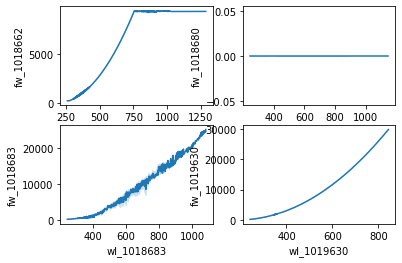

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,axs = plt.subplots(2,2)
sns.lineplot(data=df,x='wl_1018662',y='fw_1018662',ax=axs[0,0])
sns.lineplot(data=df,x='wl_1018680',y='fw_1018680',ax=axs[0,1])
sns.lineplot(data=df,x='wl_1018683',y='fw_1018683',ax=axs[1,0])
sns.lineplot(data=df,x='wl_1019630',y='fw_1019630',ax=axs[1,1])

In [13]:
# test dataset 보정
na_idxes = {}
print(f'shape : {test_df.shape}')
for col in test_df.columns :
  na_idxes[col] = test_df[test_df[col].isna() == True].index
test_df = test_df.fillna(test_df.interpolate())
print(f'null : {test_df.isna().sum()}')

shape : (6912, 18)
null : ymdhm             0
swl               0
inf               0
sfw               0
ecpc              0
tototf            0
tide_level        0
wl_1018662        0
fw_1018662        0
wl_1018680        0
fw_1018680     6912
wl_1018683        0
fw_1018683        0
wl_1019630        0
fw_1019630        0
rf_10184100       0
rf_10184110       0
rf_10184140       0
dtype: int64


In [14]:
test_df = test_df.fillna(0)
test_df.shape

(6912, 18)

## 모델링

In [ ]:
# from sklearn.model_selection import StratifiedGroupKFold
# cv = StratifiedGroupKFold(n_splits=7)
# train_dataset, val_dataset = [], []
# group=[]
# for train_idxs, test_idxs in cv.split(df[features], df[label], group):
#   print(train_idxs)
#   train_dataset.append(train_idxs)
#   val_dataset.append(test_idxs)
# train_dataset[0]

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# from sklearn.multioutput import MultiOutputRegressor
# import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso

In [34]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)
poly_pipeline.fit(df[features], df[label])
poly_pred = poly_pipeline.predict(test_df[features])

In [35]:
lasso_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Lasso(alpha=0.01)
)
lasso_pipeline.fit(df[features], df[label])
lasso_pred = lasso_pipeline.predict(test_df[features])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.205e+06, tolerance: 1.557e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e+07, tolerance: 1.214e+05
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('lasso', Lasso(alpha=0.01))])

### 저장

In [39]:
poly_pred = pd.DataFrame(poly_pred)
lasso_pred = pd.DataFrame(lasso_pred)

In [40]:
sample_submission = pd.read_csv("competition_data/sample_submission.csv")

sample_submission["wl_1018662"] = poly_pred[0]
sample_submission["wl_1018680"] = poly_pred[1]
sample_submission["wl_1018683"] = poly_pred[2]
sample_submission["wl_1019630"] = poly_pred[3]

In [41]:
sample_submission.to_csv("lasso.csv", index = False)

In [42]:
pred.head()

,0,1,2,3
0,288.302126,277.465953,277.224646,272.202682
1,288.678847,277.418266,276.869864,270.586684
2,288.529180,277.285184,275.718234,267.994465
3,289.070763,276.624486,275.449140,265.997063
4,287.851116,275.521336,274.111140,264.537039
